# Zürcher Strassenbäume

Wie grün sind Zürichs Strassen?

Zwei Datensets:
* [Strassennamenverzeichnis](https://www.stadt-zuerich.ch/geodaten/download/Strassennamenverzeichnis)
* [Bauminventar](https://www.stadt-zuerich.ch/geodaten/download/Bauminventar)


In [22]:
import pandas as pd
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import json
import xml.etree.ElementTree as ET
import requests
import re

In [23]:
# helper function for reading datasets with proper separator
# from https://github.com/opendatazurich/starter-code/blob/main/02_python//geo_bauminventar_e34d052c-50e9-451d-adca-94a0616a968c.ipynb
def get_dataset(url, layer):
    # get URL ofs WFS service
    dataset_identifier = re.search(r'\/([^\/\?]+)\?', url).group(1)
    url_geoportal = f"https://www.ogd.stadt-zuerich.ch/wfs/geoportal/{dataset_identifier}"
    print("Getting available layers from:", url_geoportal)
    
    # Parameter for GetCapabilities
    params = {
        "service": "WFS",
        "version": "1.1.0",
        "request": "GetCapabilities"
    }
    
    # send GetCapabilities
    response = requests.get(url_geoportal, params=params)

    # parse XML answer
    root = ET.fromstring(response.content)

    # define Namespace 
    namespace = {'wfs': 'http://www.opengis.net/wfs'}
    
    # Exctract available layers
    layers = [feature_type.find('wfs:Name', namespace).text for feature_type in root.findall('.//wfs:FeatureType', namespace)]
    
    print("Available layers:", layers)
    print("First layer is set as default. To chose another layer set it as typename in the get_dataset() function.")

    # s
    typename = layer
    print("Chosen typename:", typename)

    # Parameter GetFeature request
    params = {
        "service": "WFS",
        "version": "1.1.0",
        "request": "GetFeature",
        "typename": typename,
        "outputFormat": "application/json"
    }
    
    # GetFeature request
    response = requests.get(url_geoportal, params=params)

    # Load GeoJSON in GeoDataFrame
    gdf = gpd.read_file(json.dumps(response.json()))
    return gdf

In [24]:
baeume = get_dataset('https://www.stadt-zuerich.ch/geodaten/download/Bauminventar?format=geojson_link', "bauminventar")

Getting available layers from: https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Bauminventar
Available layers: ['bauminventar', 'bauminventar_3d']
First layer is set as default. To chose another layer set it as typename in the get_dataset() function.
Chosen typename: bauminventar


In [25]:
baeume.columns

Index(['id', 'baumart_deu', 'baumart_lat', 'baumnummer', 'datenstand',
       'genauigkeit', 'hoehe', 'objectid', 'pflanzjahr', 'status',
       'uuid_tlm3d', 'x', 'y', 'geometry'],
      dtype='object')

In [26]:
strassen_url = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Strassennamenverzeichnis?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=sv_str_lin"
# GetFeature request
response = requests.get(strassen_url)
# Load GeoJSON in GeoDataFrame
strassenlinien = gpd.GeoDataFrame().from_features(response.json())


In [27]:
strassenlinien

,geometry,objectid,snb_erlaeuterung,snb_str_nr_ref,snb_tafeltext_1,snb_tafeltext_2,str_bis,str_kreis,str_name,str_nr,str_planquadrat,str_st_bezeichnung,str_up_kanton,str_vb,str_von
0,"MULTILINESTRING ((8.545 47.36634, 8.54522 47.3...",5990.0,Othmar Schoeck (1886-1957): Komponist und Musi...,1771,None,None,Theaterstrasse 14,1,Schoeckstrasse,1771,O 14,gültig,2408,AA,Utoquai
1,"MULTILINESTRING ((8.49314 47.37121, 8.49278 47...",5991.0,Verkürzte Form des Flurnamens «im alten Weg» (...,53,None,None,In der Ey 60,9,Altweg,53,J 13,gültig,2406,AR,Letzigraben 231
2,"MULTILINESTRING ((8.52937 47.41429, 8.52934 47...",5992.0,Gottfried Binder (1872-1934): Letzter Gemeinde...,223,None,None,Hürststrasse 56,11,Binderweg,223,M 8,gültig,2107,AF,Zelghalde 44
3,"MULTILINESTRING ((8.53933 47.39407, 8.53883 47...",5993.0,Leonhard Schlatter: Erster namentlich bekannte...,1754,Leonhard Schlatter\r\nErster namentlich bekann...,None,Im Birkenhof,6,Schlatterweg,1754,N 10,gültig,2207,UN,Schaffhauserstrasse 91
4,"MULTILINESTRING ((8.5239 47.39675, 8.5239 47.3...",5994.0,Paul Wunderli (1852-1885): Kaufmann von Meilen...,2223,Paul Wunderli (1852-1885)\r\nEigentümer des Wa...,None,Rebbergstrasse 1,10,Wunderlistrasse,2223,L/M 10,gültig,2207,WP,Lehenstrasse 43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526,"MULTILINESTRING ((8.58505 47.37748, 8.58507 47...",8516.0,Eventuell von «Hauer» im Sinn von Wurzelhacker...,801,None,None,Alte Gockhauserstrasse,7,Hauerweg,801,R/S 12,gültig,2309,HO,Buschbergstrasse
2527,"MULTILINESTRING ((8.52931 47.33987, 8.52932 47...",8517.0,Weiblicher Vorname.,1593,None,None,Owenweg 11,2,Reginastrasse,1593,M 18,gültig,2607,WO,Lettenholzstrasse 3
2528,"MULTILINESTRING ((8.54711 47.36457, 8.54747 47...",8518.0,Guillaume-Henri Dufour (1787-1875): Schweizer ...,414,Henri Dufour (1787-1875)\r\nGeneral im Sonderb...,None,Bellerivestrasse 200,8,Dufourstrasse,414,O 14-P 16,gültig,2408+2508,RI,Falkenstrasse 6
2529,"MULTILINESTRING ((8.54017 47.37229, 8.53966 47...",8519.0,Wohl im 18. Jahrhundert nach dem Haus zum Widd...,2185,None,None,Augustinergasse 20,1,Widdergasse,2185,N 13,gültig,2407,AA,Rennweg 1


<Axes: >

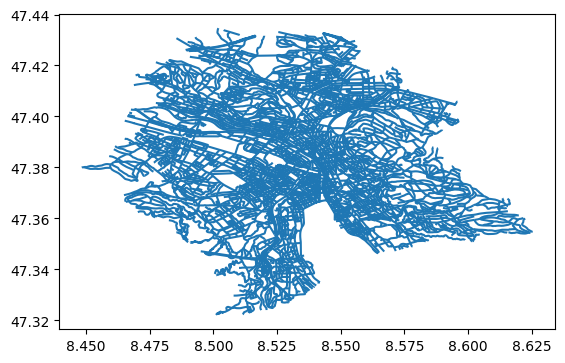

In [28]:
strassenlinien.plot()

Kartenausschnitt mit Bäumen und Strassen zur Plausibilisierung.

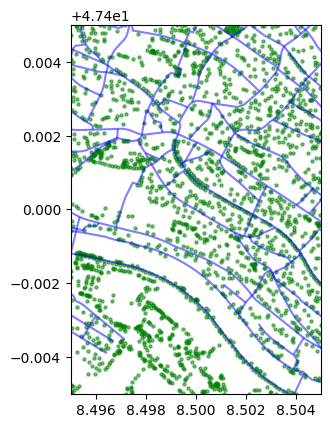

In [29]:
yppen_x, yppen_y = 8.5, 47.4
bbox = box(yppen_x - 0.005, yppen_y - 0.005, yppen_x + 0.005, yppen_y + 0.005)
_, ax = plt.subplots()
strassenlinien[strassenlinien.intersects(bbox)].plot(ax=ax, color="blue", alpha=0.5, label="Strassenlinien")
baeume[baeume.intersects(bbox)].plot(ax=ax, color="green", alpha=0.5, markersize=5, label="Bäume")
minx, miny, maxx, maxy = bbox.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

Der Baumkataster enthält auch Bäume in Parks oder Innenhöfen. Uns interessieren nur Strassenbäume. Im Wiener Original werden Strassenbreiten und Kronenflächen mit einander verschnitten. Diese Informationen haben wir nicht. Aber im Status gibt es einige Kategorien für Strassenbäume. Wir verwenden diese als Ersatz zum zu bestimmen, ob es sich um einen Baum an der Strasse handelt.

In [30]:
baeume['status'].value_counts()

status
unbekannt           72900
Grünanlage          40351
Strassenbaum        20535
Obst                 8307
Wohnsiedlungen       2788
Strassenbaum (A)     2501
Kanton               2297
Diverse               253
Schulen               148
Bund                   49
Name: count, dtype: int64

In [31]:
strassenbaeume = baeume[baeume['status'].str.contains("Strassenbaum")].to_crs(4326)

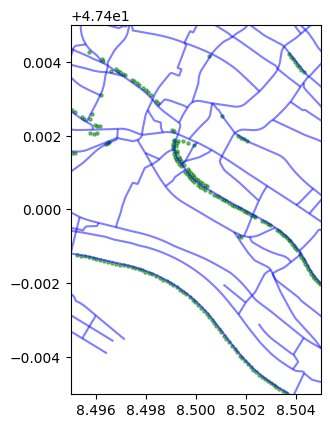

In [32]:
yppen_x, yppen_y = 8.5, 47.4
bbox = box(yppen_x - 0.005, yppen_y - 0.005, yppen_x + 0.005, yppen_y + 0.005)
_, ax = plt.subplots()
strassenlinien[strassenlinien.intersects(bbox)].plot(ax=ax, color="blue", alpha=0.5, label="Strassenlinien")
strassenbaeume[strassenbaeume.intersects(bbox)].plot(ax=ax, color="green", alpha=0.5, markersize=5, label="Bäume")
minx, miny, maxx, maxy = bbox.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

So sieht es besser aus.

Weil wir keine Strassenbreiten haben machen wir alle Strassen in einem ersten Schritt gleich breit, um zu sehen, was passiert.

In [33]:
strassenflaechen = gpd.GeoDataFrame(geometry=strassenlinien.geometry.buffer(0.0001, cap_style="flat"), crs=4326)#strassenlinien.crs)

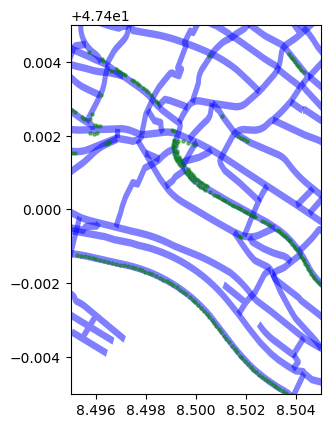

In [34]:
yppen_x, yppen_y = 8.5, 47.4
bbox = box(yppen_x - 0.005, yppen_y - 0.005, yppen_x + 0.005, yppen_y + 0.005)
_, ax = plt.subplots()
strassenflaechen[strassenflaechen.intersects(bbox)].plot(ax=ax, color="blue", alpha=0.5, label="Strassenlinien")
strassenbaeume[strassenbaeume.intersects(bbox)].plot(ax=ax, color="green", alpha=0.5, markersize=5, label="Bäume")
minx, miny, maxx, maxy = bbox.bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

# Karte Erstellen
Nun haben wir Strassenflächen und Bäume. Wir möchten die Baumdichte auf bestimmten Abschnitten schätzen. Deswegen müssen die Stassen in Abschnitte unterteilt werden. Wir nehmen Abschnitte die ca. 100m lang sind (es sind nicht genau 100m, das spielt hier aber nicht so eine Rolle).

In [35]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from shapely.ops import split, substring
from shapely.geometry import LineString

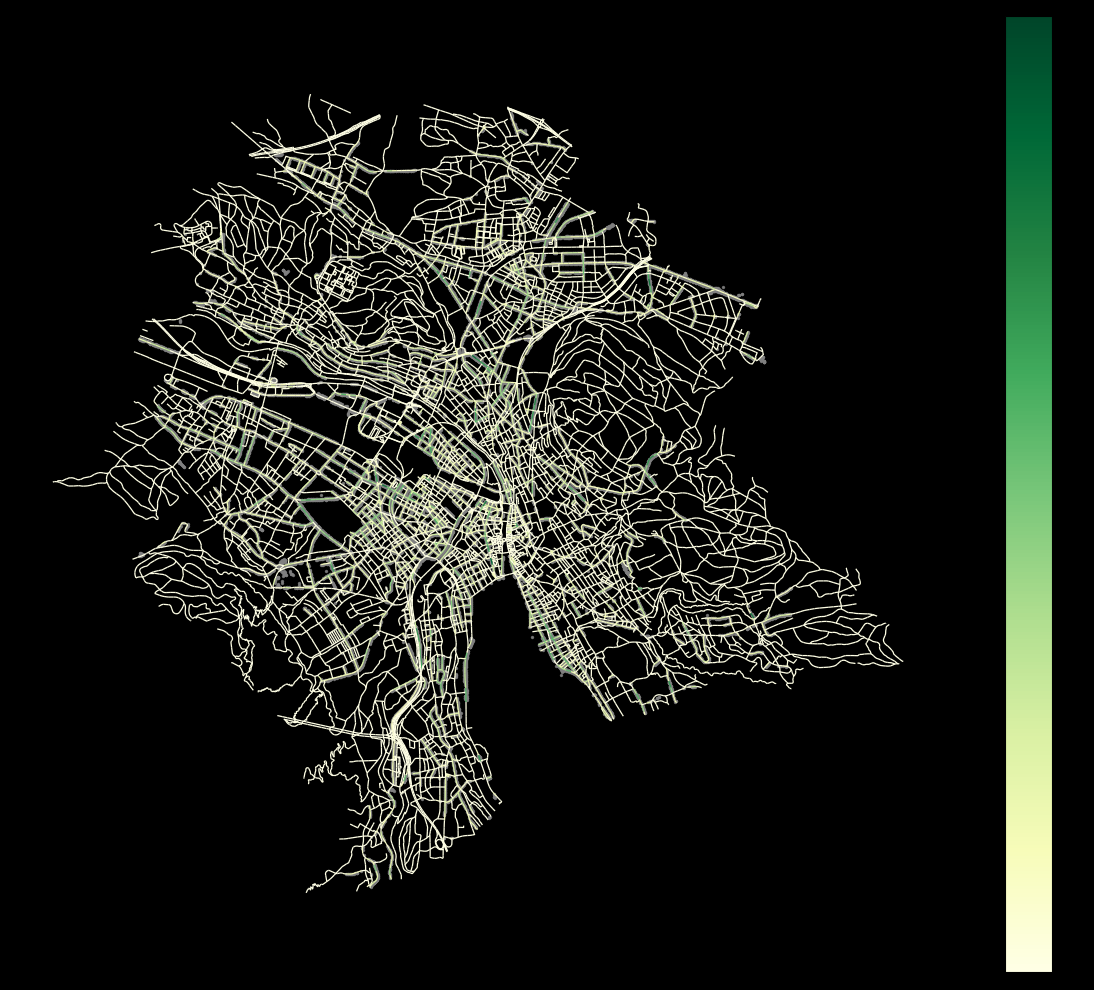

In [36]:


# Hilfsfunktion: Linie in ca. 100 m (≈0.001°) Segmente aufteilen
def split_line_by_length_deg(line, segment_length_deg):
    if line.length <= segment_length_deg:
        return [line]
    
    segments = []
    start = 0
    while start < line.length:
        end = min(start + segment_length_deg, line.length)
        seg = substring(line, start, end)
        segments.append(seg)
        start += segment_length_deg
    return segments

# 0. CRS setzen, falls noch nicht vorhanden
strassenlinien.set_crs(epsg=4326, inplace=True)
strassenbaeume.set_crs(epsg=4326, inplace=True)

# Optional: Nur Bäume mit status="Strassenbaum"
strassenbaeume = baeume[baeume["status"].str.contains("Strassenbaum", na=False)]

# 1. MultiLineStrings auftrennen in einzelne LineStrings
strassenlinien = strassenlinien.explode(index_parts=False)
strassenlinien = strassenlinien[strassenlinien.geometry.type == "LineString"]

# 2. Segmentieren (0.001° ≈ 100 m)
segment_length_deg = 0.001
segments = []
for idx, row in strassenlinien.iterrows():
    geom = row.geometry
    if isinstance(geom, LineString) and geom.length > 0:
        for seg in split_line_by_length_deg(geom, segment_length_deg):
            segments.append({"geometry": seg})

segment_gdf = gpd.GeoDataFrame(segments, crs=strassenlinien.crs)

# 3. Pufferung (10 m) in EPSG:2056 (Schweizer Projektion)
segment_gdf_proj = segment_gdf.to_crs(epsg=2056)
segment_gdf_proj["geometry"] = segment_gdf_proj.buffer(10, cap_style=2)
segment_gdf = segment_gdf_proj.to_crs(epsg=4326)

# 4. Spatial Join: Welche Bäume liegen in welchem Segment?
baeume_in_segmenten = gpd.sjoin(strassenbaeume, segment_gdf, how="inner", predicate="intersects")

# 5. Schattenhöhe je Segment berechnen
schatten = baeume_in_segmenten.groupby("index_right")["hoehe"].sum().reset_index()
schatten.rename(columns={"hoehe": "schatten_summe"}, inplace=True)

# 6. Schattenwerte zuweisen
segment_gdf["schatten_summe"] = schatten.set_index("index_right")["schatten_summe"]
segment_gdf["schatten_summe"] = segment_gdf["schatten_summe"].fillna(0)

# 7. Normalisieren für Farbschema
scaler = MinMaxScaler()
segment_gdf["schatten_norm"] = scaler.fit_transform(segment_gdf[["schatten_summe"]])

# 8. Plot
fig, ax = plt.subplots(figsize=(12, 10), facecolor='black')

strassenbaeume.plot(ax=ax, color="grey", markersize=2, alpha=0.8)
segment_gdf.plot(column="schatten_norm", cmap="YlGn", ax=ax, legend=True, linewidth=0.2, edgecolor="none")

plt.title("Schattenwirkung durch Strassenbäume (ca. 100 m Abschnitte)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()


# Karte als HTML
Das sieht schon nicht schlecht aus. Wir möchten die Karte aber gern im Internet publizieren. Deswegen wäre es besser, wenn wir eine HTML Version haben, in der man herumzoomen kann. Das geht mit folium.

In [37]:
import folium
import branca.colormap as cm
from folium import FeatureGroup, LayerControl

In [38]:
# Daten in WGS84
segment_gdf_wgs84 = segment_gdf.to_crs(epsg=4326)
strassenbaeume_wgs84 = strassenbaeume.to_crs(epsg=4326)

# Farblegende (Schattenintensität)
colormap = cm.linear.YlGn_09.scale(0, segment_gdf["schatten_norm"].max())
colormap.caption = "Schattenintensität (normalisiert)"

# Hauptkarte initialisieren
m = folium.Map(location=[47.3769, 8.5417], zoom_start=14, tiles="CartoDB dark_matter")

# ───────────────────────────────────────────────
# 1. Strassen-Heatmap Layer
# ───────────────────────────────────────────────
heatmap_layer = FeatureGroup(name="Schattenwirkung (100m-Abschnitte)", show=True)

for _, row in segment_gdf_wgs84.iterrows():
    folium.GeoJson(
        row["geometry"],
        style_function=lambda feature, value=row["schatten_norm"]: {
            'fillColor': colormap(value),
            'color': None,
            'fillOpacity': 0.7,
        }
    ).add_to(heatmap_layer)

heatmap_layer.add_to(m)
colormap.add_to(m)

# ───────────────────────────────────────────────
# 2. Bäume als Layer 
# ───────────────────────────────────────────────
tree_layer = FeatureGroup(name="Bäume (manuell einblendbar)", show=False)

for _, row in strassenbaeume_wgs84.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color='white',
        fill=True,
        fill_opacity=0.5
    ).add_to(tree_layer)

tree_layer.add_to(m)

# ───────────────────────────────────────────────
# 3. Statisches Infofeld (immer sichtbar)
# ───────────────────────────────────────────────
info_html = """
<div style="
     position: fixed;
     top: 10px;
     left: 10px;
     width: 330px;
     z-index: 9999;
     background-color: rgba(0, 0, 0, 0.75);
     padding: 15px;
     border-radius: 10px;
     box-shadow: 0 0 10px rgba(0,0,0,0.5);
     color: white;
     font-size: 13px;
     line-height: 1.5;
">
  <h4 style="margin-top: 0; color: lightgreen;">Schatten-Heatmap Zürcher Strassen</h4>
  <p>
    Diese Karte zeigt die Schattenwirkung von Strassenbäumen.
    Die Strassen sind in ca. 100 m lange Abschnitte unterteilt.
    Die Farbskala basiert auf der <b>Gesamthöhe der Bäume</b> innerhalb jedes Abschnitts.
  </p>
  <p style="font-size: 11px; color: #ccc;">
    Quellen: <a href="https://www.stadt-zuerich.ch/geodaten/download/Bauminventar">Bauminventar</a>, <a href="https://www.stadt-zuerich.ch/geodaten/download/Strassennamenverzeichnis">Strassennamenverzeichnis</a>  (Stadt Zürich Open Data)<br>
    Inspiration: https://elias-gander.github.io/2025-6-17-wiener-strassenbaeume
  </p>
</div>
"""

m.get_root().html.add_child(folium.Element(info_html))

# ───────────────────────────────────────────────
# 4. Layer-Kontrolle
# ───────────────────────────────────────────────
LayerControl(collapsed=False).add_to(m)

# ───────────────────────────────────────────────
# 5. Karte speichern
# ───────────────────────────────────────────────
m.save("karte_schatten.html")